In [1]:
import cv2
import numpy as np
import math
import sys
from colormap import rgb2hex
from matplotlib import pyplot as plt
import time
from thermalMap import ThermalMap


In [2]:
def determineIfOuterRing(contour, point):
    if cv2.pointPolygonTest(contour, point, True) <= 0:
        return True
    else:
        return False
    
def determineQuadrant(width, height, points):
    q1, q2, q3, q4 = (0,0,0,0)
    for x in range(len(points)):
        if (points[x][0][0] < width/2) and (points[x][0][1] < height/2):
            q1 += 1
        elif (points[x][0][0] >= width/2) and (points[x][0][1] < height/2):
            q2 += 1
        elif (points[x][0][0] >= width/2) and (points[x][0][1] >= height/2):
            q3 += 1
        else:
            q4 += 1
    maxVal = max(q1,q2,q3,q4)

    if (q1 == maxVal):
        return 1
    elif (q2 == maxVal):
        return 2
    elif (q3 == maxVal):
        return 3
    else:
        return 4
             

In [3]:
def determineOuterConours(contour):
    outerContourIdx = list(range(0, len(contour)-1))
    print(outerContourIdx)
    for c in range(len(contour)-1):
        for comp in range(len(contour)-1):
            point = (int(contour[c][0][0][0]), int(contour[c][0][0][1]))
            if determineIfOuterRing(contour[comp], point):
                continue
            else:
                outerContourIdx.remove(c)
                break
    
    return outerContourIdx

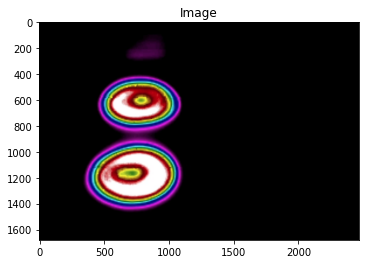

In [4]:
thermalObj = ThermalMap()

thermalObj.newTempRange("tempScale.jpg", 220, 20)
img = cv2.imread("stove.jpg")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.show()

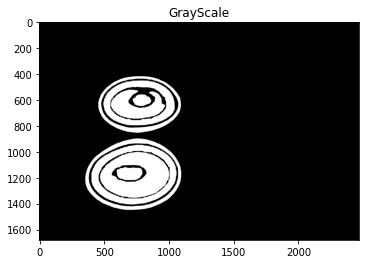

In [5]:
#Apply adaptive threshold
img_blur = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.title('GrayScale')
plt.show()

In [6]:
#Perform Morphology
se = np.ones((7,7), dtype='uint8')
image_close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, se)


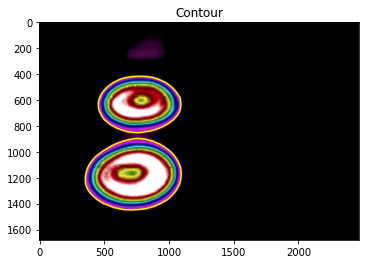

Burner 4 is on!
Average Temp of Burner 4 is: 141.47 °C
Burner 1 is on!
Average Temp of Burner 1 is: 87.11 °C


In [8]:
contours, hierarchy = cv2.findContours(thresh, mode=cv2.RETR_EXTERNAL, method =cv2.CHAIN_APPROX_SIMPLE)

image_cpy = img.copy()
cv2.drawContours(image=image_cpy, contours=contours, contourIdx=-1, color=(0,255,255),
                thickness=10, lineType=cv2.LINE_AA)

plt.imshow(cv2.cvtColor(image_cpy, cv2.COLOR_BGR2RGB))
plt.title('Contour')
plt.show()

lst_intensities = []

# For each list of contour points...
for i in range(len(contours)):
    # Create a mask image that contains the contour filled in
    cimg = np.zeros_like(img)
    
    cv2.drawContours(cimg, contours, i, color=255, thickness=-1)

    # Access the image pixels and create a 1D numpy array
    pts = np.where(cimg == 255)
    
    lst_intensities.append(img[pts[0], pts[1]])

for i in range(len(lst_intensities)):
    totalTemp = 0
    for p in range(len(lst_intensities[i])):
        rgbInt = thermalObj.rgb2int((lst_intensities[i][p][0], lst_intensities[i][p][1], lst_intensities[i][p][2]))
        temp = thermalObj.get_temp(rgbInt)
        totalTemp += temp
    burner = determineQuadrant(img.shape[1], img.shape[0], contours[i])
    print("Burner", burner, "is on!")
    avgTemp = totalTemp/(len(lst_intensities[0]))
    print("Average Temp of Burner", burner, "is: %.2f" % avgTemp, "°C")
        
    